id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
Before Removing Outliers:

Stats for Distance Traveled:
Max: 851.9684420612176
Mean: 2.8748204947796165
Std Dev: 4.429580039640526
Outlier Cutoff Value: 16.163560613701193




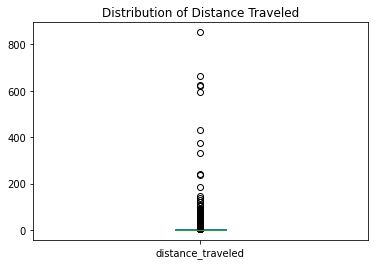

Distance Traveled Outliers Removed: 19


After Removing Outliers:

Stats for Distance Traveled:
Max: 92.45577823517027
Mean: 2.8706505074779236
Std Dev: 4.193495596590587
Outlier Cutoff Value: 15.451137297249685




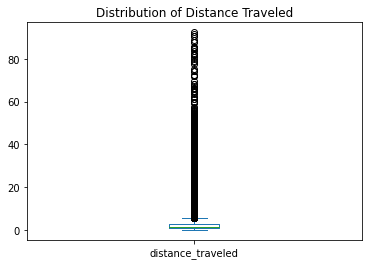

In [0]:
import math 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from math import radians

def getDistance(x1, y1, x2, y2):
    pickup = [float(x1), float(y1)]
    dropoff = [float(x2), float(y2)]
    pickupInRadians = [radians(_) for _ in pickup]
    dropOffInRadians = [radians(_) for _ in dropoff]
    result = haversine_distances([pickupInRadians, dropOffInRadians])
    return result[0][1] * 6371000/1000

# returns the max value, mean, std deviation, and calculated outlier value based on a dataframe column
def getStats(column):
    max_value = np.max(column.astype(float))
    std_dev = np.std(column.astype(float))
    mean = np.mean(column.astype(float))
    outlier_value = mean + (3 * std_dev)
    return (max_value, mean, std_dev, outlier_value)

def showStats(dataFrame):
    result = getStats(dataFrame['distance_traveled'])
    print(f'Stats for Distance Traveled:\nMax: {result[0]}\nMean: {result[1]}\nStd Dev: {result[2]}\nOutlier Cutoff Value: {result[3]}\n\n')

    dataFrame['distance_traveled'].plot(kind='box', title='Distribution of Distance Traveled')
    plt.show() 

data = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/luke.couture@ucalgary.ca/train.csv").toPandas()

# check for null values
print(data.isnull().sum(axis = 0))

# copy numerical columns
number_column_names = ['passenger_count', 'trip_duration']
df = data[number_column_names].astype(int).copy()

# remove outliers found on first EDA attempt
df.drop(df[(df.trip_duration.astype(int) > 16000) | (df.trip_duration.astype(int) < 0)].index, inplace=True)
df.drop(df[(df.passenger_count.astype(int) > 6) | (df.passenger_count.astype(int) < 1)].index, inplace=True)

# Calculate distance of taxi trip
df['distance_traveled'] = data.apply(lambda x: getDistance(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

# Show stats Before removing outliers
print(f'Before Removing Outliers:\n')
showStats(df)

# Drop outliers and count them
count_before = len(df['distance_traveled'])
df.drop(df[(df.distance_traveled.astype(float) > 100)].index, inplace=True)
count_after = len(df['distance_traveled'])

print(f'Distance Traveled Outliers Removed: {count_before - count_after}\n\n')

# Show stats after removing outliers
print(f'After Removing Outliers:\n')
showStats(df)